In [8]:
import numpy as np
import math
from PIL import Image
import time

In [2]:
import tensorflow as tf
import os
cwd = os.getcwd()

In [3]:
cwd

'/notebooks'

In [3]:
os.listdir('.\input')

['GM - 1-01 Prelude.wav',
 'GM - 1-02 Opening ~ Bombing Mission.wav',
 'GM - 1-03 Makou Reactor.wav',
 'GM - 1-04 Anxious Heart .wav',
 "GM - 1-05 Tifa's Theme.wav",
 "GM - 1-06 Barett's Theme.wav",
 'GM - 1-07 Hurry!.wav',
 'GM - 1-08 Lurking in the Darkness.wav',
 'GM - 1-09 ShinRa Company.wav',
 'GM - 1-10 Fighting.wav',
 'GM - 1-12 Flowers Blooming in the Church.wav',
 "GM - 1-13 Turk's Theme.wav",
 'GM - 1-14 Underneath the Rotting Pizza.wav',
 'GM - 1-15 Opressed People.wav',
 'GM - 1-16 Honeybee Manor.wav',
 'GM - 1-17 Who Are You.wav',
 'GM - 1-19 Infiltrating ShinRa Tower.wav',
 'GM - 1-20 Still More Fighting.wav',
 "GM - 1-21 Red XIII's Theme.wav",
 'GM - 1-22 Crazy Motorcycle.wav',
 'GM - 1-23 Holding My Thoughts in My Heart.wav',
 'GM - 2-01 FFVII Main Theme.wav',
 'GM - 2-02 Ahead on Our Way.wav',
 'GM - 2-04 On That Day, 5 Years Ago.wav',
 'GM - 2-05 Farm Boy.wav',
 'GM - 2-07 Electric de Chocobo.wav',
 'GM - 2-08 Cinco de Chocobo.wav',
 'GM - 2-09 Chasing the Black-Caped

In [4]:
import scipy.io.wavfile

In [10]:
channel1=audData[:] #left
channel2=audData[:] #right

In [23]:
files = os.listdir('.\input')

for file in files:
    rate,audData=scipy.io.wavfile.read('.\input\\'+file)
    print(audData.shape[0] / rate / 60)
    signal_fragment = audData[0:60*rate] #train on first minute of every song
    print(file)
    img = generateSpectrogramForWave(signal_fragment)
    scipy.io.wavfile.write(file, rate, signal_fragment)
    img.save(file+".png","PNG")

1.0
GM - 1-01 Prelude.wav
20.14s
20.28s
3.74981875
GM - 1-02 Opening ~ Bombing Mission.wav
19.77s
20.20s
1.683340625
GM - 1-03 Makou Reactor.wav
19.75s
19.34s
1.8297697916666666
GM - 1-04 Anxious Heart .wav
19.42s
19.93s
2.500007291666667
GM - 1-05 Tifa's Theme.wav
20.51s
19.61s
1.6666739583333334
GM - 1-06 Barett's Theme.wav
19.61s
19.78s
1.2024760416666667
GM - 1-07 Hurry!.wav
19.59s
19.60s
1.2061666666666668
GM - 1-08 Lurking in the Darkness.wav
20.31s
19.48s
2.083340625
GM - 1-09 ShinRa Company.wav
19.68s
20.14s
1.3306364583333334
GM - 1-10 Fighting.wav
19.68s
19.72s
2.4333416666666663
GM - 1-12 Flowers Blooming in the Church.wav
19.14s
19.96s
1.9575854166666666
GM - 1-13 Turk's Theme.wav
19.37s
19.22s
2.1583416666666664
GM - 1-14 Underneath the Rotting Pizza.wav
18.58s
18.50s
1.285721875
GM - 1-15 Opressed People.wav
18.89s
19.27s
1.9627520833333334
GM - 1-16 Honeybee Manor.wav
18.80s
18.72s
1.2642552083333334
GM - 1-17 Who Are You.wav
18.23s
18.14s
1.7954635416666667
GM - 1-19 In

FileNotFoundError: [Errno 2] No such file or directory: '.\\input\\spectrogram.png'

In [36]:
audData.shape[0] / rate / 60

2.6926895833333333

In [23]:
audData.dtype

dtype('int16')

In [37]:
signal_fragment = channel1[0:60*rate] #train on first minute of every song

### Create FFT

In [12]:
FFT_LENGTH = 1024
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

In [13]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, 
                        magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, 
                       phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

16.78s
19.89s


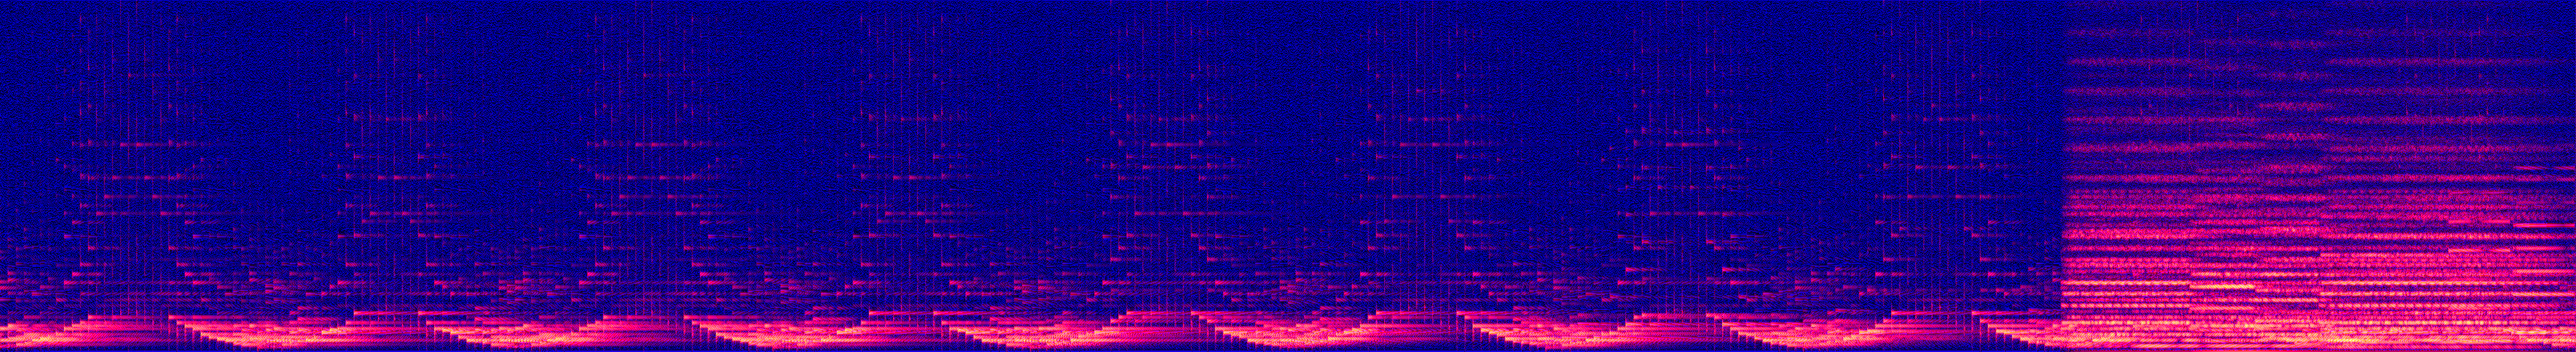

In [14]:
def generateSpectrogramForWave(signal, file):
    start_time = time.time()
    global magnitudeMin
    global magnitudeMax
    global phaseMin
    global phaseMax
    buffer = np.zeros(int(signal.size + WINDOW_STEP - (signal.size % WINDOW_STEP)))
    buffer[0:len(signal)] = signal
    height = int(FFT_LENGTH / 2 + 1)
    width = int(len(buffer) / (WINDOW_STEP) - 1)
    magnitudePixels = np.zeros((height, width))
    phasePixels = np.zeros((height, width))

    for w in range(width):
        buff = np.zeros(FFT_LENGTH)
        stepBuff = buffer[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH]
        # apply hanning window
        stepBuff = stepBuff * np.hanning(WINDOW_LENGTH)
        buff[0:len(stepBuff)] = stepBuff
        #buff now contains windowed signal with step length and padded with zeroes to the end
        fft = np.fft.rfft(buff)
        for h in range(len(fft)):
            #print(buff.shape)
            #return
            magnitude = math.sqrt(fft[h].real**2 + fft[h].imag**2)
            if magnitude > magnitudeMax:
                magnitudeMax = magnitude 
            if magnitude < magnitudeMin:
                magnitudeMin = magnitude 

            phase = math.atan2(fft[h].imag, fft[h].real)
            if phase > phaseMax:
                phaseMax = phase
            if phase < phaseMin:
                phaseMin = phase
            magnitudePixels[height-h-1,w] = magnitude
            phasePixels[height-h-1,w] = phase
    rgbArray = generateLinearScale(magnitudePixels, phasePixels,
                                  magnitudeMin, magnitudeMax, phaseMin, phaseMax)
    elapsed_time = time.time() - start_time
    print('%.2f' % elapsed_time, 's', sep='')
    img = Image.fromarray(rgbArray, 'RGB')
    return img


### Recover from png

In [42]:
def recoverSignalFromSpectrogram(filePath):
    start_time = time.time()
    img = Image.open(os.getcwd()+"\\spectrograms\\"+filePath)
    data = np.array( img, dtype='uint8' )
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals \
    = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
    
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    scipy.io.wavfile.write("recovered-"+filepath+".wav", rate, recovered)
    elapsed_time = time.time() - start_time
    print('%.2f' % elapsed_time, 's', sep='')
recoverSignalFromSpectrogram("GM - 1-04 Anxious Heart .wav.png")

16.61s
